MOTIVATION

Detailed simulation of qubit-cavity coupling with two-photon sideband transitions to verify the simplified simulation of the cQED atomic beam experiment.

NOTES

- 1 ns unit for time
- Conventions:
  - [qubit, resonator ]
  - Qubit: blue
  - Resonator: red

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import plots
import os
import shutil
import time
from datetime import datetime
from glob import glob
from copy import copy
from supports import *
from qutip import *
from scipy.special import erf
from scipy.signal import argrelextrema

options = Options()
options.store_states=True

In [197]:
Nq = 2   # number of levels in qubit
Nc = 10  # number of levels in resonator 1

wq = 6.5*2*pi    # qubit frequency
wc = 4*2*pi    # resonator 1 frequency
delta = wq - wc  # detuning
Ec = 0.16*2*pi  # Anharmonicity (charging energy)
g = 0.2*2*pi  # drive frequency resonator 1, coupling between qubit and resonator 1

Omega = 0.3*2*pi  # amplitude of sideband transitions
wsb = 1.273*2*pi #1/4*(3*wq - wc - sqrt((wq + wc)**2 - 4*Omega**2))  # pump drive frequency

In [206]:
T = 500  # simulation time [ns]
Np = 100*int(T)     # number of discrete time steps for which to store the output
print("timestep =", 1e3*np.round(T/Np, 5), "ps")

timestep = 10.0 ps


In [207]:
# Qubit operators
b = tensor(destroy(Nq), qeye(Nc))
nq = b.dag()*b

# Cavity operators
a = tensor(qeye(Nq), destroy(Nc))
nc = a.dag()*a

# Jaynes-Cummings Hamiltonian
Hjc = wq*nq + wc*nc - Ec/2*b.dag()*b.dag()*b*b - g*(a*b.dag() + b*a.dag())

# Sideband transitions
Hsb = Omega*(b + b.dag())

# Hamiltonian arguments
H_args = {'T' : T, 'wsb' : wsb}

# Expectation operators
e_ops = [nq, nc]

In [208]:
H = [Hjc, [Hsb, sideband]]  # complete Hamiltonian
psi0 = tensor(psi_pi(Nq), basis(Nc, 0))  # initial state

# Select these options for bdf method
# options.method = 'bdf'
# options.rtol = 1e-10
# options.atol = 1e-10

# Select these options for adams method
options.nsteps = 1000
options.rtol = 1e-12
options.atol = 1e-12
options.max_step = 0

Np_per_batch = Np/10  # number of time points per batch

In [209]:
batches = create_batches(0, T, Np, Np_per_batch)

# Remove existing progress folder
for folder in glob("/home/student/thesis/prog_*"):
    shutil.rmtree(folder)

# Make new progress folder
now = datetime.now()
nowstr = now.strftime("%y_%m_%d_%H_%M_%S")
folder = "/home/student/thesis/prog_" + nowstr
os.makedirs(folder)

# Calculate!
for num, tlist in enumerate(batches):
    print(num+1, "/", len(batches), ":", int(np.round(100*(num+1)/len(batches))), "%")
    result = mesolve(H, psi0, tlist, [], e_ops=e_ops, args=H_args, options=options)
    saveprog(result, num, folder)
    psi0 = copy(result.states[-1])
    del result
end_calc = datetime.now()
print("Evolution completed in {} s".format((end_calc - now).total_seconds()))

1 / 10 : 10 %
2 / 10 : 20 %
3 / 10 : 30 %
4 / 10 : 40 %
5 / 10 : 50 %
6 / 10 : 60 %
7 / 10 : 70 %
8 / 10 : 80 %
9 / 10 : 90 %
10 / 10 : 100 %
Evolution completed in 57.121186 s


In [210]:
srcfolder = folder # "/home/student/thesis/"
selection = All # (0, T)
reduction = 5

combine_batches(srcfolder, selection, reduction,
                quants=['times', 'expect'], return_data=False)
end_comb = datetime.now()
print("Batches combined    in {} s".format((end_comb - end_calc).total_seconds()))

Batches combined    in 1.901531 s


In [211]:
tfile = open(srcfolder + "/times.pkl", 'rb')
tdata = pickle.load(tfile)
times = tdata['data']
tfile.close()
del tdata

# sfile = open(srcfolder + "/states.pkl", 'rb')
# sdata = pickle.load(sfile)
# states = sdata['data']
# sfile.close()
# del sdata

efile = open(srcfolder + "/expect.pkl", 'rb')
edata = pickle.load(efile)
expect = edata['data']
efile.close()
del edata

In [212]:
# obj = 0    # 0 = qubit, 1 = cavity

# plt.figure(figsize=[6,3])
# if obj == 0:
#     plt.plot(times, expect[obj], color='b', label='Qubit')
# elif obj == 1:
#     plt.plot(times, expect[obj], color='r', label='Cavity')

# # VARIABLE PLOT SETTINGS    
# # plt.xlim([0, 10])
# # plt.ylim([0, 0.52])

# plt.xlabel("$t$ [ns]")
# if obj > 0:
#     plt.ylabel("$n_c$")
#     plt.title("Cavity population")
# else:
#     plt.ylabel("$n_q$")
#     plt.title("Qubit population")
# plt.legend()

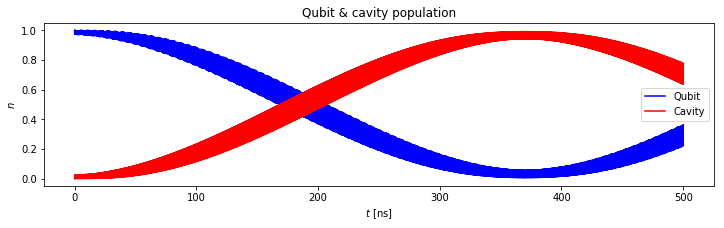

In [215]:
plt.figure(figsize=[12,3])
plt.plot(times, expect[0], color='b', label='Qubit')
plt.plot(times, expect[1], color='r', label='Cavity')
# plt.xlim([180, 210])
# plt.ylim([0, 2.8])
plt.xlabel("$t$ [ns]")
plt.ylabel("$n$")
plt.legend()
plt.title("Qubit & cavity population")
plt.show()